### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@dev`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


#### Install py4j
In addition install py4j v0.10.9.1-mm from my github clone
`git clone https://github.com/sedgewickmm18/py4j`

Install with
```
cd py4j-java
./gradlew clean assemble # build java jars
cd ..
pip install .  # install python and jars
```

#### Install timeseries-insights
Checkout WatFore forecasting library first

`git clone https://github.ibm.com/Common-TimeSeries-Analytics-Library/WatFore`

then timeseries-insights

`git clone https://github.ibm.com/Common-TimeSeries-Analytics-Library/timeseries-insights`

Finally apply a patch for allow for a callback server IP other than 127.0.0.1

`curl https://raw.githubusercontent.com/sedgewickmm18/tsi/master/context.py.patch | patch -p1`


Build WatFore
```
cd WatFore
mvn clean install -DskipTests
```

Build timeseries-insights
```
cd ../timeseries-insights
mvn clean install -DskipTests
```

Build the python distribution of tspy
```
cd python
python setup.py sdist
```

Install it

`pip install dist/tspy-2.0.5.0.tar.gz`


#### Run timeseries-insights as docker container

`docker run -p 25332:25332 -p 25333:25333 sedgewickmm18/tsi`

* port 25333 exposes the default port for the java server
* port 25332 allows for optional ssh based port forwarding (should not be necessary)

The patch above allows for callback server IP addresses other than 127.0.0.1, i.e. the python client that also acts as callback server for python lambda processing can listen to a docker bridge IP address. In my case I'm running it from my laptop on `172.17.0.1` while the container with the java process has IP address `172.17.0.2`.

##### Caveat:

The java process attempts to listen to IPv4 **and** IPv6 addresses so have to enable IPv6 for your docker bridge with

`sudo vi /etc/docker/daemon.json`

so that it looks similar to

```
{
    "insecure-registries" : ["localhost:32000"],
    "ipv6": true,
    "fixed-cidr-v6": "2001:db8:1::/64"
}
```

Then restart the docker daemon with

`systemctl restart docker`

and check with

`docker network inspect bridge`

In [1]:
# Real life data

import logging
import threading
import itertools
import modin.pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)                 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
# setting to make life easier
Temperature='KW'

df_input = pd.read_csv('BP_DATA/IoTData.csv', parse_dates=['DATETIME'], comment='#')
df_input.rename(columns={'DATETIME': 'timestamp'}, inplace=True)
#df_input = df_input.asfreq('H')
df_input.set_index('timestamp', inplace=True)


In [3]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-10-26T11:03:51.013 INFO iotfunctions.dbtables.__init__ Init FileModelStore


In [4]:
df_i = df_input
df_i['entity'] = 'demand'

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.reset_index().set_index(['entity','timestamp']).dropna()

df_i.head(2)

TEMP_AIR  UMIDADE_REL      KW     KW2
entity timestamp                                                 
demand 2019-09-15 00:00:00      18.7           80  690.48  69.048
       2019-09-15 01:00:00      18.2           83  685.44  68.544

In [5]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['demand']]
df_inputm2.reset_index(level=[0], inplace=True)

# predicted just means normalized - need to modify the BaseEstimatorFunction superclass
df_inputm2

,entity,TEMP_AIR,UMIDADE_REL,KW,KW2
timestamp,,,,,
2019-09-15 00:00:00,demand,18.7,80,690.480000,69.048000
2019-09-15 01:00:00,demand,18.2,83,685.440000,68.544000
2019-09-15 02:00:00,demand,18.2,83,656.880000,65.688000
2019-09-15 03:00:00,demand,18.2,83,655.200000,65.520000
2019-09-15 04:00:00,demand,18.3,82,660.240000,66.024000
...,...,...,...,...,...
2020-08-31 16:00:00,demand,20.8,68,525.840027,52.584003
2020-08-31 17:00:00,demand,19.6,72,504.000000,50.400000
2020-08-31 18:00:00,demand,19.5,75,535.919983,53.591998


In [6]:
# start the callback server

#from tspy import TSContext
import tspy
from tspy.data_structures.context import TSContext 
from py4j.java_gateway import JavaGateway, GatewayParameters, CallbackServerParameters


gateway = JavaGateway(gateway_parameters=GatewayParameters(address=u'172.17.0.2',
                                  auth_token='DZQv45+bq4TTHSF3FH2RoYqLoGjY2zMcojcQQpRFZMA='),
            callback_server_parameters=CallbackServerParameters(daemonize=True,port=25334,address=u'172.17.0.1',
                         auth_token='DZQv45+bq4TTHSF3FH2RoYqLoGjY2zMcojcQQpRFZMA=',daemonize_connections=True))



2020-10-26T11:03:59.935 INFO py4j.java_gateway.run Callback Server Starting
2020-10-26T11:03:59.936 INFO py4j.java_gateway.run Socket listening on ('172.17.0.1', 25334)


In [7]:
df_i

TEMP_AIR  UMIDADE_REL          KW        KW2
entity timestamp                                                        
demand 2019-09-15 00:00:00      18.7           80  690.480000  69.048000
       2019-09-15 01:00:00      18.2           83  685.440000  68.544000
       2019-09-15 02:00:00      18.2           83  656.880000  65.688000
       2019-09-15 03:00:00      18.2           83  655.200000  65.520000
       2019-09-15 04:00:00      18.3           82  660.240000  66.024000
...                              ...          ...         ...        ...
       2020-08-31 16:00:00      20.8           68  525.840027  52.584003
       2020-08-31 17:00:00      19.6           72  504.000000  50.400000
       2020-08-31 18:00:00      19.5           75  535.919983  53.591998
       2020-08-31 19:00:00      19.0           76  517.440003  51.744000
       2020-08-31 20:00:00      19.0           76  485.519990  48.551999

[8336 rows x 4 columns]

In [47]:
import datetime

df = df_i.reset_index()[['entity','timestamp','KW']] #['entity'=='04714B6046D5']
df = df[df['entity']=='demand']


tsc = TSContext(gateway=gateway, jvm=gateway.jvm, daemonize=True)

model = tspy.forecasters.arima(500)

model_map = {
        'demand': model,
}

In [48]:
df

,entity,timestamp,KW
0,demand,2019-09-15 00:00:00,690.480000
1,demand,2019-09-15 01:00:00,685.440000
2,demand,2019-09-15 02:00:00,656.880000
3,demand,2019-09-15 03:00:00,655.200000
4,demand,2019-09-15 04:00:00,660.240000
...,...,...,...
8331,demand,2020-08-31 16:00:00,525.840027
8332,demand,2020-08-31 17:00:00,504.000000
8333,demand,2020-08-31 18:00:00,535.919983
8334,demand,2020-08-31 19:00:00,517.440003


In [49]:
dfs = df[0:6000]
mts_raw = tsc.multi_time_series\
        .df_observations(dfs, dfs.keys()[0], dfs.keys()[1], dfs.keys()[2], granularity=datetime.timedelta(milliseconds=1))\
        .with_trs(granularity=datetime.timedelta(minutes=1)) \
        .transform(tsc.duplicate_transforms.combine_duplicate_time_ticks(lambda x: float(sum(x) / len(x))))

In [50]:
dfss = mts_raw.to_df()

In [51]:
dfss[dfss['value'] <  0]

,timestamp,key,value


In [52]:
model.update_model(dfss['timestamp'].astype(int).tolist(), dfss['value'].tolist())
#model.update_model(mts_raw)

In [53]:
model

Forecasting Model
  Algorithm: RegularARIMAAlgorithm [armaAlgorithm=RegularARMAAlgorithm [dataHistory=WeightedHistory [weights=[0.5198987675092025, 0.23729453208764717], history=com.ibm.watson.pm.util.CircularBuffer@75cc001f, historyLength=2, dataCount=6044], errorHistory=WeightedHistory [weights=null, history=null, historyLength=0, dataCount=0], dataMean=632.2331707317359, minTrainingData=80, pMin=0, pMax=5, qMin=0, qMax=5, forceModel=false], differencer=null, minTrainingData=82, diffOrder=-1]

In [54]:
forecasts = mts_raw.forecast(100, model_map, confidence=0.97)

In [55]:
df2 = mts_raw.to_df()

In [56]:
df2.describe()

,timestamp,value
count,6.000000e+03,6000.000000
mean,2.632341e+07,625.105600
std,1.046591e+05,154.196329
min,2.614176e+07,8.400000
25%,2.623264e+07,497.279999
50%,2.632371e+07,613.200000
75%,2.641412e+07,764.400025
max,2.650434e+07,944.160000


In [57]:
for k, series in forecasts.items():
    for k2 in series:
        print(k2)
        print(k2.value)
        ser = pd.Series
        df2 = df2.append({'timestamp': k2.time_tick, 'key': k, 'value': k2.value['value']}, ignore_index=True)

2020-10-26T14:03:14.684 INFO py4j.java_gateway.run Callback Connection ready to receive messages
2020-10-26T14:03:14.686 INFO py4j.java_gateway.run Received command c on object id p504
2020-10-26T14:03:14.688 INFO py4j.java_gateway.run Callback Connection ready to receive messages
2020-10-26T14:03:14.689 INFO py4j.java_gateway.run Received command c on object id p404
TimeStamp: 26504400     Value: {value=541.420179895362, lower_bound=362.15645389173096, upper_bound=720.6839058989931, error=82.60657152443488}
2020-10-26T14:03:14.692 INFO py4j.java_gateway.run Received command c on object id p404
{value=541.420179895362, lower_bound=362.15645389173096, upper_bound=720.6839058989931, error=82.60657152443488}
2020-10-26T14:03:14.693 INFO py4j.java_gateway.run Received command c on object id p404
2020-10-26T14:03:14.699 INFO py4j.java_gateway.run Received command c on object id p505
2020-10-26T14:03:14.700 INFO py4j.java_gateway.run Received command c on object id p405
TimeStamp: 26504460  

2020-10-26T14:03:14.771 INFO py4j.java_gateway.run Received command c on object id p417
TimeStamp: 26505180     Value: {value=626.0258839142416, lower_bound=268.153600636289, upper_bound=983.8981671921943, error=164.91123454956087}
2020-10-26T14:03:14.771 INFO py4j.java_gateway.run Received command c on object id p417
{value=626.0258839142416, lower_bound=268.153600636289, upper_bound=983.8981671921943, error=164.91123454956087}
2020-10-26T14:03:14.772 INFO py4j.java_gateway.run Received command c on object id p417
2020-10-26T14:03:14.777 INFO py4j.java_gateway.run Received command c on object id p518
2020-10-26T14:03:14.777 INFO py4j.java_gateway.run Received command c on object id p418
TimeStamp: 26505240     Value: {value=627.1922451087611, lower_bound=270.0332153995904, upper_bound=984.3512748179318, error=164.58255995789557}
2020-10-26T14:03:14.778 INFO py4j.java_gateway.run Received command c on object id p418
{value=627.1922451087611, lower_bound=270.0332153995904, upper_bound=9

{value=631.81839600794, lower_bound=273.4975342233348, upper_bound=990.1392577925452, error=165.11794414619936}
2020-10-26T14:03:14.842 INFO py4j.java_gateway.run Received command c on object id p430
2020-10-26T14:03:14.845 INFO py4j.java_gateway.run Received command c on object id p531
2020-10-26T14:03:14.846 INFO py4j.java_gateway.run Received command c on object id p431
TimeStamp: 26506020     Value: {value=631.8963329631011, lower_bound=273.3921255840965, upper_bound=990.4005403421058, error=165.2024316847276}
2020-10-26T14:03:14.846 INFO py4j.java_gateway.run Received command c on object id p431
{value=631.8963329631011, lower_bound=273.3921255840965, upper_bound=990.4005403421058, error=165.2024316847276}
2020-10-26T14:03:14.847 INFO py4j.java_gateway.run Received command c on object id p431
2020-10-26T14:03:14.851 INFO py4j.java_gateway.run Received command c on object id p532
2020-10-26T14:03:14.851 INFO py4j.java_gateway.run Received command c on object id p432
TimeStamp: 2650

2020-10-26T14:03:14.919 INFO py4j.java_gateway.run Received command c on object id p444
TimeStamp: 26506800     Value: {value=632.2106630239625, lower_bound=273.1303153128846, upper_bound=991.2910107350405, error=165.46792308452456}
2020-10-26T14:03:14.919 INFO py4j.java_gateway.run Received command c on object id p444
{value=632.2106630239625, lower_bound=273.1303153128846, upper_bound=991.2910107350405, error=165.46792308452456}
2020-10-26T14:03:14.920 INFO py4j.java_gateway.run Received command c on object id p444
2020-10-26T14:03:14.923 INFO py4j.java_gateway.run Received command c on object id p545
2020-10-26T14:03:14.923 INFO py4j.java_gateway.run Received command c on object id p445
TimeStamp: 26506860     Value: {value=632.2148922648272, lower_bound=273.1099764224451, upper_bound=991.3198081072094, error=165.47924433250398}
2020-10-26T14:03:14.924 INFO py4j.java_gateway.run Received command c on object id p445
{value=632.2148922648272, lower_bound=273.1099764224451, upper_bound

{value=632.2316667527989, lower_bound=272.78001963954785, upper_bound=991.68331386605, error=165.63902167377273}
2020-10-26T14:03:14.984 INFO py4j.java_gateway.run Received command c on object id p457
2020-10-26T14:03:14.987 INFO py4j.java_gateway.run Received command c on object id p558
2020-10-26T14:03:14.988 INFO py4j.java_gateway.run Received command c on object id p458
TimeStamp: 26507640     Value: {value=632.2319493532859, lower_bound=272.76179855397635, upper_bound=991.7021001525954, error=165.64754836291357}
2020-10-26T14:03:14.988 INFO py4j.java_gateway.run Received command c on object id p458
{value=632.2319493532859, lower_bound=272.76179855397635, upper_bound=991.7021001525954, error=165.64754836291357}
2020-10-26T14:03:14.989 INFO py4j.java_gateway.run Received command c on object id p458
2020-10-26T14:03:14.993 INFO py4j.java_gateway.run Received command c on object id p559
2020-10-26T14:03:14.993 INFO py4j.java_gateway.run Received command c on object id p459
TimeStamp:

2020-10-26T14:03:15.062 INFO py4j.java_gateway.run Received command c on object id p471
TimeStamp: 26508420     Value: {value=632.2330891184735, lower_bound=272.47205841221995, upper_bound=991.994119824727, error=165.78158882036504}
2020-10-26T14:03:15.063 INFO py4j.java_gateway.run Received command c on object id p471
{value=632.2330891184735, lower_bound=272.47205841221995, upper_bound=991.994119824727, error=165.78158882036504}
2020-10-26T14:03:15.064 INFO py4j.java_gateway.run Received command c on object id p471
2020-10-26T14:03:15.067 INFO py4j.java_gateway.run Received command c on object id p572
2020-10-26T14:03:15.067 INFO py4j.java_gateway.run Received command c on object id p472
TimeStamp: 26508480     Value: {value=632.2331044537598, lower_bound=272.44503546229345, upper_bound=992.0211734452262, error=165.79404834071045}
2020-10-26T14:03:15.068 INFO py4j.java_gateway.run Received command c on object id p472
{value=632.2331044537598, lower_bound=272.44503546229345, upper_bou

{value=632.2331652782873, lower_bound=272.12681029381224, upper_bound=992.3395202627623, error=165.94071780492857}
2020-10-26T14:03:15.135 INFO py4j.java_gateway.run Received command c on object id p484
2020-10-26T14:03:15.139 INFO py4j.java_gateway.run Received command c on object id p585
2020-10-26T14:03:15.139 INFO py4j.java_gateway.run Received command c on object id p485
TimeStamp: 26509260     Value: {value=632.2331663030006, lower_bound=272.12123597212366, upper_bound=992.3450966338776, error=165.9432869819818}
2020-10-26T14:03:15.140 INFO py4j.java_gateway.run Received command c on object id p485
{value=632.2331663030006, lower_bound=272.12123597212366, upper_bound=992.3450966338776, error=165.9432869819818}
2020-10-26T14:03:15.141 INFO py4j.java_gateway.run Received command c on object id p485
2020-10-26T14:03:15.144 INFO py4j.java_gateway.run Received command c on object id p586
2020-10-26T14:03:15.144 INFO py4j.java_gateway.run Received command c on object id p486
TimeStamp:

2020-10-26T14:03:15.209 INFO py4j.java_gateway.run Received command c on object id p498
TimeStamp: 26510040     Value: {value=632.233170435805, lower_bound=271.87134263923383, upper_bound=992.5949982323763, error=166.05844230834845}
2020-10-26T14:03:15.210 INFO py4j.java_gateway.run Received command c on object id p498
{value=632.233170435805, lower_bound=271.87134263923383, upper_bound=992.5949982323763, error=166.05844230834845}
2020-10-26T14:03:15.211 INFO py4j.java_gateway.run Received command c on object id p498
2020-10-26T14:03:15.215 INFO py4j.java_gateway.run Received command c on object id p599
2020-10-26T14:03:15.215 INFO py4j.java_gateway.run Received command c on object id p499
TimeStamp: 26510100     Value: {value=632.233170491411, lower_bound=271.8553079140144, upper_bound=992.6110330688075, error=166.06583130052582}
2020-10-26T14:03:15.216 INFO py4j.java_gateway.run Received command c on object id p499
{value=632.233170491411, lower_bound=271.8553079140144, upper_bound=9

2020-10-26T14:08:29.233 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


Text(0, 0.5, 'Electricity Consumption')

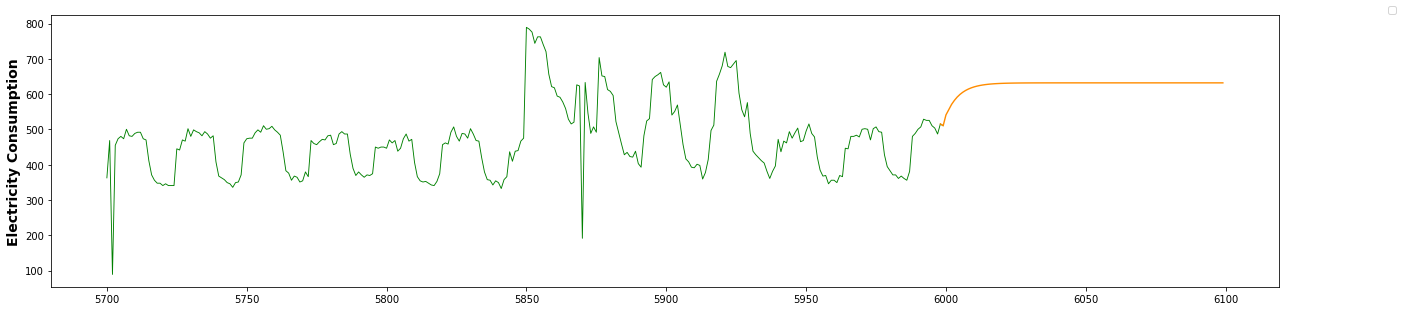

2020-10-26T14:08:37.554 INFO py4j.java_gateway.run Received command  on object id 
2020-10-26T14:08:37.556 INFO py4j.java_gateway.close Closing down callback connection


In [63]:
dftail = df2.tail(400)
fig, ax = plt.subplots(1, 1, figsize=(22,5))
#ax.plot(df2.index, df2['value'],linewidth=0.7,color='green',label=Temperature)
ax.plot(dftail[0:300].index, dftail[0:300]['value'],linewidth=0.9,color='green')
ax.plot(dftail[298:].index, dftail[298:]['value'],linewidth=1.4,color='darkorange')

ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('Electricity Consumption',fontsize=14,weight="bold")